In [1]:
#gerekli kutuphaneleri yukle
!pip install hmmlearn seqeval


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ad0f2346759ae44b063371011746ad762594d44692920064328f26f5df460216
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [2]:
#dosya yukleme
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Yüklenen dosya: {filename}")


Saving veriseti.conll to veriseti.conll
Yüklenen dosya: veriseti.conll


In [3]:
#veriyi oku
def load_conll_data(filepath):
    sentences = []
    sentence = []
    with open(filepath, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("-DOCSTART-"):
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    token = parts[0]
                    label = parts[-1]
                    sentence.append((token, label))
        if sentence:
            sentences.append(sentence)
    return sentences

data = load_conll_data(filename)
print(f"Toplam cümle sayısı: {len(data)}")
print("Örnek cümle:", data[0])


Toplam cümle sayısı: 38
Örnek cümle: [('Microsoft', 'B-ORG'), ('Türkiye', 'B-COUNTRY'), ("'den", 'O'), ('35', 'B-AGE'), ('yaşındaki', 'I-AGE'), ('yazılım', 'B-PROFESSION'), ('mühendisi', 'I-PROFESSION'), ('Ahmet', 'B-PERSON'), ('Bey', 'I-PERSON'), ('İstanbul', 'B-CITY'), ("'a", 'O'), ('taşındı', 'O'), ('.', 'O')]


In [4]:
#kelime etiketlerini sayisallastir ve padding yap
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

sentences = [[token for token, label in sent] for sent in data]
labels = [[label for token, label in sent] for sent in data]

# Kelimeleri sayisallastir
word_tokenizer = Tokenizer(lower=True, oov_token='OOV')
word_tokenizer.fit_on_texts(sentences)
X = word_tokenizer.texts_to_sequences(sentences)

# Etiketleri encode et
label_encoder = LabelEncoder()
flat_labels = [lab for sent in labels for lab in sent]
label_encoder.fit(flat_labels)
y = [label_encoder.transform(sent) for sent in labels]

max_len = max(len(s) for s in X)

X_padded = pad_sequences(X, maxlen=max_len, padding='post')
y_padded = pad_sequences(y, maxlen=max_len, padding='post', value=label_encoder.transform(['O'])[0])

print(f"Kelime sayısı: {len(word_tokenizer.word_index)}")
print(f"Etiket sayısı: {len(label_encoder.classes_)}")
print(f"Maksimum cümle uzunluğu: {max_len}")


Kelime sayısı: 344
Etiket sayısı: 25
Maksimum cümle uzunluğu: 29


In [5]:
#modeli eğit
from hmmlearn import hmm
X_train = np.concatenate(X_padded).reshape(-1, 1)
y_train = np.concatenate(y_padded)

lengths = [len(s) for s in X_padded]

model = hmm.MultinomialHMM(n_components=len(label_encoder.classes_), n_iter=100)
model.fit(X_train, lengths)


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=25, n_iter=100,
               n_trials=array([77, 12, 78, ..., 63,  2,  0]),
               random_state=RandomState(MT19937) at 0x7B353C82F140)

In [6]:
#tahmin ve degerlendirme
from seqeval.metrics import classification_report, f1_score
X_test = X_train
lengths_test = lengths

y_pred = model.predict(X_test, lengths_test)

def to_labels(seqs, lengths):
    out = []
    idx = 0
    for length in lengths:
        out.append([label_encoder.inverse_transform([seqs[i]])[0] for i in range(idx, idx+length)])
        idx += length
    return out

y_true_labels = to_labels(y_train, lengths)
y_pred_labels = to_labels(y_pred, lengths)

print("--- CLASSIFICATION REPORT ---")
print(classification_report(y_true_labels, y_pred_labels))
print("F1-score:", f1_score(y_true_labels, y_pred_labels))


--- CLASSIFICATION REPORT ---
                precision    recall  f1-score   support

           AGE       0.00      0.00      0.00        14
          CITY       0.00      0.00      0.00        27
       COUNTRY       0.08      0.23      0.12        13
          DATE       0.00      0.00      0.00        16
         EMAIL       0.00      0.00      0.00         6
           FAX       0.00      0.00      0.00         2
LOCATION-OTHER       0.00      0.00      0.00         3
           ORG       0.00      0.00      0.00        13
        PERSON       0.00      0.00      0.00        22
         PHONE       0.00      0.00      0.00         5
    PROFESSION       0.01      0.03      0.02        33
         STATE       0.00      0.00      0.00         4
        STREET       0.00      0.00      0.00         5
           URL       0.00      0.00      0.00         6
           ZIP       0.00      0.00      0.00         4

     micro avg       0.00      0.02      0.01       173
     macro avg  

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
#Confusion Matrix grafik

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels):
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]

    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.xlabel('Tahmin Edilen Etiketler')
    plt.ylabel('Gerçek Etiketler')
    plt.title('Confusion Matrix')
    plt.show()


In [16]:
#pie chart
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

def plot_label_distribution_pie_v2(y_true, threshold=2):
    all_labels = [label for sentence in y_true for label in sentence if label != 'O']
    label_counts = Counter(all_labels)

    df = pd.DataFrame(label_counts.items(), columns=['Entity', 'Count']).sort_values(by='Count', ascending=False)
    total = df['Count'].sum()
    df['Percent'] = 100 * df['Count'] / total

    small = df[df['Percent'] < threshold]
    large = df[df['Percent'] >= threshold]

    if not small.empty:
        others_sum = small['Count'].sum()
        others_percent = 100 * others_sum / total
        others_df = pd.DataFrame({'Entity': ['Diğer'], 'Count': [others_sum], 'Percent': [others_percent]})
        large = pd.concat([large, others_df], ignore_index=True)

    labels = large['Entity']
    sizes = large['Count']

    fig, ax = plt.subplots(figsize=(8,8))
    wedges, texts, autotexts = ax.pie(sizes, labels=None, autopct='%1.1f%%', startangle=140, pctdistance=0.85)

    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig.gca().add_artist(centre_circle)

    kw = dict(arrowprops=dict(arrowstyle="-"), bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.72), zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        ax.annotate(labels.iloc[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y), horizontalalignment=horizontalalignment, **kw)

    plt.title("Entity Dağılımı - Gruplanmış Donut Chart", fontsize=16)
    plt.show()


In [18]:
#bar grafigi
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

def plot_label_distribution_bar(y_true):
    all_labels = [label for sentence in y_true for label in sentence if label != 'O']
    label_counts = Counter(all_labels)
    df = pd.DataFrame(label_counts.items(), columns=['Entity', 'Count']).sort_values(by='Count', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Entity', data=df)
    plt.title('Entity Dağılımı - Bar Grafiği')
    plt.xlabel('Örnek Sayısı')
    plt.ylabel('Entity')
    plt.show()


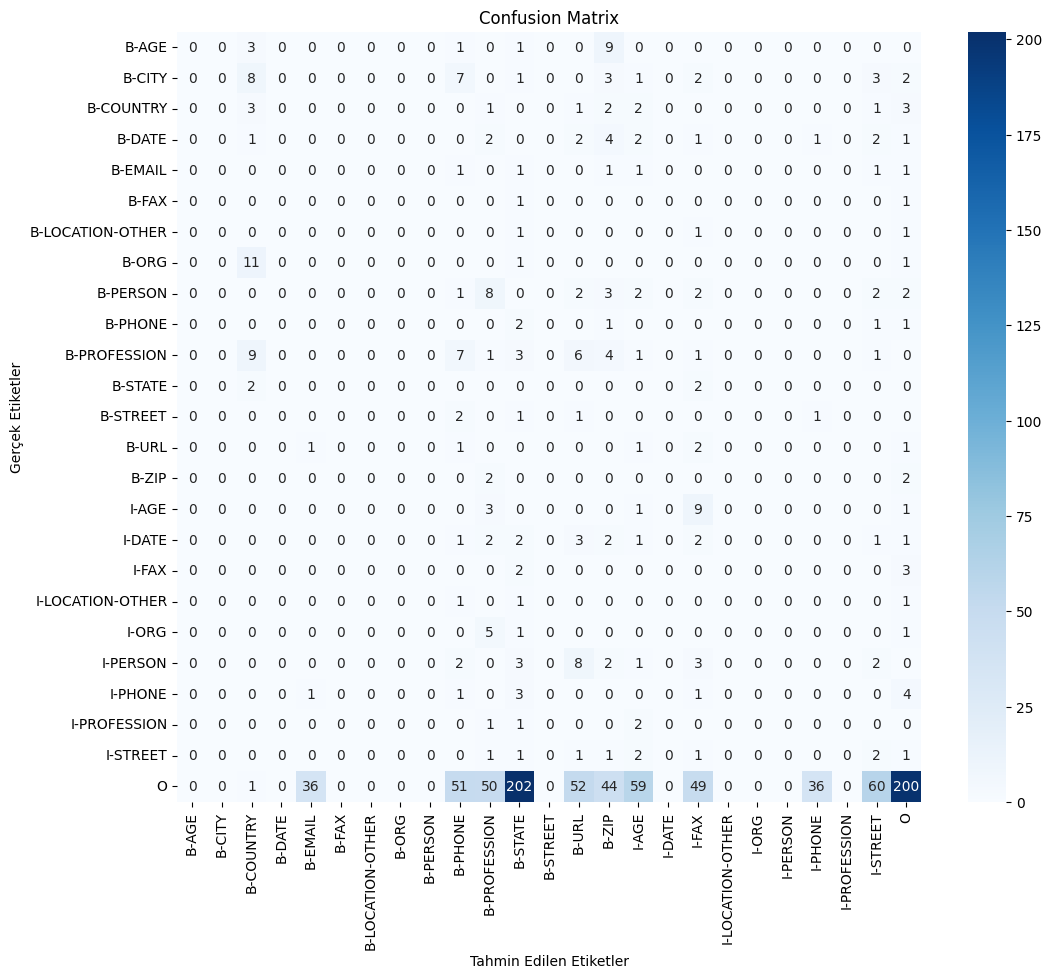

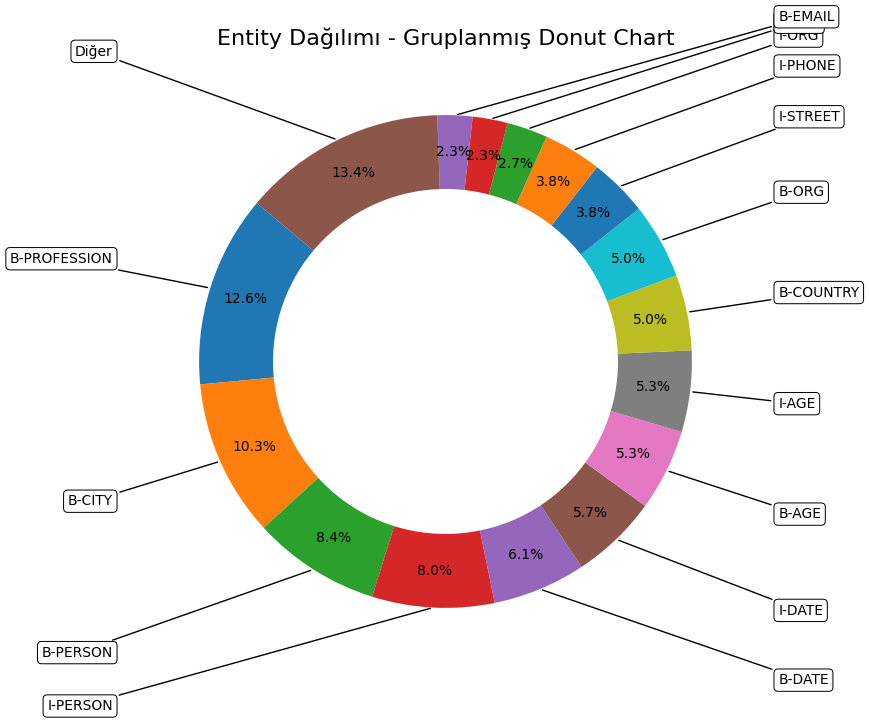

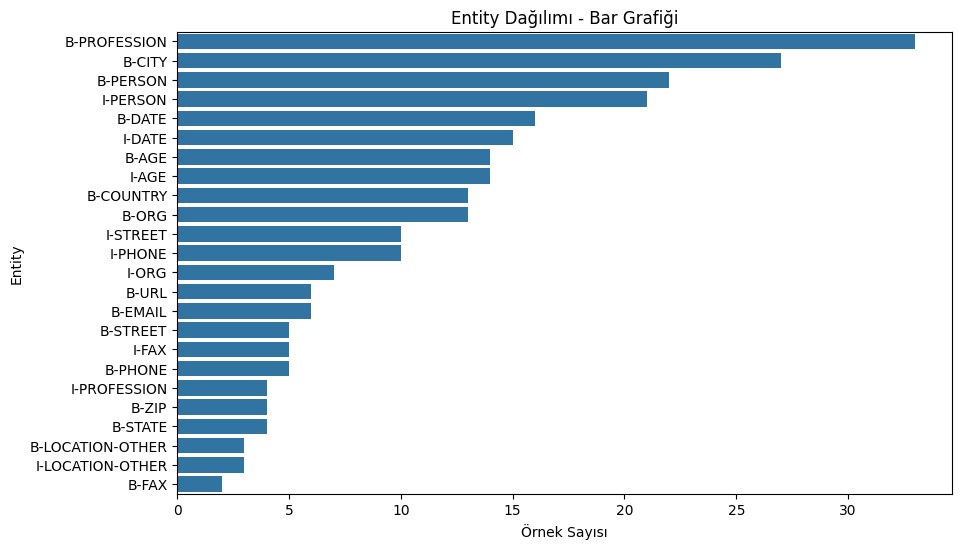

In [19]:
#Gorsellestirme metotlarini cagir
labels = list(label_encoder.classes_)

plot_confusion_matrix(y_true_labels, y_pred_labels, labels)
plot_label_distribution_pie_v2(y_true_labels, threshold=2)
plot_label_distribution_bar(y_true_labels)



In [20]:
#Renkli etiketleme (Annotated HTML)
from IPython.core.display import display, HTML

def generate_annotated_html(tokens, labels):
    entity_colors = {
        "PERSON": "#F48FB1",
        "CITY": "#A5D6A7",
        "PROFESSION": "#FFB74D",
        "EMAIL": "#F8BBD0",
        "STREET": "#B0BEC5",
        "PHONE": "#90CAF9",
        "AGE": "#4DD0E1",
        "ORG": "#80CBC4",
        "URL": "#CE93D8",
        "COUNTRY": "#AED581",
        "DATE": "#81D4FA",
        "STATE": "#E6EE9C",
        "ZIP": "#FFD54F",
        "O": "#FFFFFF"  # Etiket olmayan kelimeler beyaz
    }

    html = "<div style='font-family:monospace; line-height:2;'>"

    for token, label in zip(tokens, labels):
        main_label = label.split("-")[-1] if label != "O" else "O"
        color = entity_colors.get(main_label, "#E0E0E0")
        if main_label != "O":
            html += f"<span style='background-color:{color}; padding:4px; margin:2px; border-radius:4px;'>{token} <small><strong>{main_label}</strong></small></span> "
        else:
            html += f"{token} "

    html += "</div>"

    display(HTML(html))


In [21]:
#test verisindeki 5. cumlenin renklendirilmesi
sample_index = 5

tokens = [word_tokenizer.index_word.get(idx, '') for idx in X_padded[sample_index] if idx != 0]
labels = y_true_labels[sample_index]  # Gerçek etiketler veya y_pred_labels[sample_index]

generate_annotated_html(tokens, labels)
